### Group 8
- Nimrod Grandpierre
- Jonas Riber Jørgensen
- Johan Ulstrup
- Laura Fur

# Project 5: NJ tree construction
This project is about making an efficient implementation of the neighbor-joining (NJ) algorithm as shown on slide 50 in the slides about tree reconstruction and compare its performance to the NJ programs QuickTree and RapidNJ that you know from project 4.

## <span style="color:cornflowerblue">Problem<span/>
You should make a program that implements the NJ algorithm as shown in the slides about tree reconstruction. Your program program should take a distance matrix in phylip-format as input and produce a tree in newick-format as output. You should know these formats from project 4. Your aim is to make your implementation as efficient as possible.

The file example_slide4.phy contains the distance matrix (in phylip-format) from slide 4 in the slides about tree reconstruction. With this matrix as input, your program should produce the tree that is also shown on slide 4 in the slides about tree reconstruction.

In [134]:
import pandas as pd
import numpy as np
from read_phylip import *
from correct_DM import *
from NJ_print import *
import os
from io import StringIO
from Bio import Phylo

### Implementation

Nimrod's implementation:

In [ ]:
"""
We need to calculate the Q matrix at every iteration of the NJ algorithm
We need to have Ri and Rj calculated in order to obtain the Q matrix
Ri and Rj: the sum of all the distances of the remaining "labels"/"sequences" leading into Ri/Rj
    Qij = (n - 2) * Dij - Ri - Rj
The non-identical pair with the lowest net divergence are joined to form a new node u
Then we need to calculate the distances from u to the rest of the nodes

Steps:
1. Having D, calculate Q matrix
2. Pick the pair with lowest score
3. Calculate distances from original nodes to newly created node
    d(f, u) = 1/2 (Dfg) + 1/(2 * (n - 2)) * [Rf - Rg]
    d(g, u) = d(f, g) - d(f, u)
4. Calculate new distance matrix using
    Duk = 1/2 [Dfk + Dgk - Dfg]
5. Repeat steps 1-4 until we have three remaining nodes in D
"""

def initiate_dist_matrix(file):
    raw = open(file, "r").read()
    lines_sep = raw.split('\n')

    dim = int(lines_sep[0])
    dist_matrix = np.zeros((dim, dim))

    lines_sep = lines_sep[1:]
    
    labels = []

    for index, line in enumerate(lines_sep):
        if line != "":
            parsed_line = line.split()
            label = parsed_line[0]
            labels.append(label)
            dist_matrix[index, :] = parsed_line[1:]

    return dist_matrix, labels


def calculate_Q(dist_matrix):
    dim = dist_matrix.shape[0]
    Q = np.zeros((dim, dim))

    for i in range(dim):
        for j in range(dim):
            if i == j:
                Q[i][j] = 0
            else:
                r_i, r_j = 0, 0
                for k in range(dim):
                    r_i += dist_matrix[i][k]
                    r_j += dist_matrix[j][k]
                Q[i][j] = (dim - 2) * dist_matrix[i][j] - r_i - r_j
    
    return Q


def find_lowest_pair(Q_matrix):
    dim = Q_matrix.shape[0]
    min_value = float('inf')

    for i in range(dim):
        for j in range(dim):
            if Q_matrix[i][j] < min_value:
                min_value = Q_matrix[i][j]
                min_index = (i, j)
    
    return min_index


def calc_dist_from_orig_to_joined_node(index, dist_matrix):
    # We use these distances as branch length for the tree that we're building

    dim = dist_matrix.shape[0]
    i, j = index
    r_i, r_j = 0, 0
    for k in range(dim):
        r_i += dist_matrix[i][k]
        r_j += dist_matrix[j][k]

    # Calculating distances from the two joined leaves to the new inner node
    d_ki = round((1/2) * dist_matrix[i][j] + (1/(2 * (dim - 2))) * (r_i - r_j), 5)
    d_kj = dist_matrix[i][j] - d_ki

    return d_ki, d_kj


def update_dist_matrix(index, dist_matrix):
    dim = dist_matrix.shape[0]
    new_dist_matrix = np.zeros((dim - 1, dim - 1)) # -1 because we are deleting 2 rows and columns and adding 1

    # Deleting the rows and columns corresponding to the nodes that we are joining together
    f, g = index
    to_delete = [f, g]

    mask = np.ones(dist_matrix.shape[0], dtype = bool)
    mask[to_delete] = False
    temp_matrix = dist_matrix[mask, :][:, mask]

    """
    Copying remaining values from the original distance matrix to the updated one,
    Calculating distances from new node to rest of the nodes
    """
    dim_temp = temp_matrix.shape[0]

    for n in range(dim_temp):
        for m in range(dim_temp):
            new_dist_matrix[n][m] = temp_matrix[n][m]
    
    index_in_new_dist_matrix = 0

    for k in range(dim):
        if k == f or k == g:
            continue
        else:
            new_dist_matrix[dim - 2][index_in_new_dist_matrix] = (1/2) * (dist_matrix[f][k] + dist_matrix[k][g] - dist_matrix[f][g])
            new_dist_matrix[index_in_new_dist_matrix][dim - 2] = (1/2) * (dist_matrix[f][k] + dist_matrix[k][g] - dist_matrix[f][g])
            index_in_new_dist_matrix += 1

    return new_dist_matrix


def calculate_remaining_distances(dist_matrix):
    i, j, m = 0, 1, 2

    # m is the last inner node inserted before the termination
    d_vi = round((1/2) * (dist_matrix[i][j] + dist_matrix[i][m] - dist_matrix[j][m]), 5)
    d_vj = round((1/2) * (dist_matrix[i][j] + dist_matrix[j][m] - dist_matrix[i][m]), 5)
    d_vm = round((1/2) * (dist_matrix[i][m] + dist_matrix[j][m] - dist_matrix[i][j]), 5)

    return d_vi, d_vj, d_vm


def newickify(node_to_children, root_node):
    visited_nodes = set()

    def newick_render_node(name, distance):
        assert name not in visited_nodes, "Error: The tree may not be circular!"

        if name not in node_to_children:
            # Leafs
            return F'{name}:{distance}'
        else:
            # Nodes
            visited_nodes.add(name)
            children = node_to_children[name]
            children_strings = [newick_render_node(child, children[child]) for child in children.keys()]
            children_strings = ",".join(children_strings)
            return F'({children_strings}){name}:{distance}'

    newick_string = newick_render_node(root_node, 0) + ';'

    # Ensure no entries in the dictionary are left unused.
    assert visited_nodes == set(node_to_children.keys()), "Error: some nodes aren't in the tree"

    return newick_string


def neighbor_joining(path_to_dist_matrix):
    """
    Create the input in Newick format somehow, then just make Phylo eat that and draw the tree
    With each addition of a joined node, append an item to the 'labels' list
    """
    D, labels = initiate_dist_matrix(path_to_dist_matrix)
    newick_dict = {}
    inner_node_counter = 1

    while D.shape[0] > 3:
        dict_nested = {}

        Q = calculate_Q(D)
        min_index = find_lowest_pair(Q)
        dist_to_joined = calc_dist_from_orig_to_joined_node(min_index, D)

        # Creating nested dictionary to the two joined leaves and their distance from the new inner node
        dict_nested[labels[min_index[0]]] = dist_to_joined[0]
        dict_nested[labels[min_index[1]]] = dist_to_joined[1]

        inner_node = f"J{inner_node_counter}"
        newick_dict[inner_node] = dict_nested

        # Updating the labels list by adding the new inner node and getting rid of the two joined leaves
        labels.append(inner_node)
        labels = [labels[i] for i in range(len(labels)) if i not in min_index]

        new_dist_matrix = update_dist_matrix(min_index, D)
        D = new_dist_matrix
        inner_node_counter += 1

    # Termination
    d_vi, d_vj, d_vm = calculate_remaining_distances(D)

    inner_node = f"J{inner_node_counter}"

    dict_nested = {}
    dict_nested[labels[0]] = d_vi
    dict_nested[labels[1]] = d_vj
    dict_nested[labels[2]] = d_vm

    newick_dict[inner_node] = dict_nested
    print(newick_dict)

    newick_output = newickify(newick_dict, inner_node)

    return newick_output


# treedata = neighbor_joining("./data/example_slide4.phy")
# treedata = neighbor_joining("./data/89_Adeno_E3_CR1.phy")
treedata = neighbor_joining("unique_distance_matrices/304_A1_Propeptide.phy")
handle = StringIO(treedata)
tree = Phylo.read(handle, "newick")

Phylo.draw(tree, branch_labels = lambda c: c.branch_length if c.branch_length else "")

Laura's implementation:

In [187]:
def NJ(S: list, DM: dict):

    T = []

    while len(S) > 3:

        def cluster(S, DM):
            nonlocal T

            """ Step 1: Correcting the input distance matrix and choosing a sequence pair to cluster """
            
            N = compute_N(S, DM)  # Correcting the distance matrix.

            min_distances = {i: min((distance, idx) for idx, distance in enumerate(row) if distance != 0.0) for i, row in N.items()}  # Finding the shortest distance and its index for each cluster in N.

            C1 = min(min_distances, key = lambda k: min_distances[k][0])          # Cluster 1 is the cluster with the shortest distance among all clusters' minimum distances.
            C2_idx = min_distances[C1][1]                                         # Extract the index for cluster 2. 
            C2 = S[C2_idx]                                                        # Get cluster 2 from S.

            """ Step 2+3: Calculating distances to new cluster and adding edges, (k, i) and (k, j) and adding k to T """

            # Adding edges, (k, i) and (k, j):
            dij = {seq_i: DM[seq_i] for seq_i in DM.keys()}
            ri = {seq_i: round((1 / (len(DM) - 2)) * np.sum(DM_i), 2) for i, (seq_i, DM_i) in enumerate(DM.items()) for j in range(len(DM_i)) if i != j}
            
            diu = round(0.5 * dij[C1][C2_idx] + 0.5 * (ri[C1] - ri[C2]), 2)      # Distance from cluster 1 in k to common node.
            dju = round(dij[C1][C2_idx] - diu, 2)                                # Distance from cluster 2 in k to common node.

            T.append([C1, diu, C2, dju])

            # Calculating distances from other clusters to k:
            dijk = {}
            for i, seq_i in enumerate(DM.keys()):
                if seq_i not in (C1, C2):
                    dik = DM[C1][i]
                    djk = DM[C2][i]
                    dij = DM[C1][C2_idx]
                    dijk[seq_i] = round(0.5 * (dik + djk - dij), 2)
                dijk[(C1, C2)] = 0                                               # (Converting k to tuple, as lists cannot be used as keys).

            """ Step 4: Update distance matrix """

            UDM = DM.copy()                                                      # Create template for the updated distance matrix from the input distance matrix.

            UDM[(C1, C2)] = UDM.pop(C1)                                          # Overwrite key for cluster 1 in k. Note that this puts the key for k in the last position of the dictionary.
            del UDM[C2]                                                          # Delete key for cluster 2 in k.

            for seq, dists in UDM.items():
                UDM[seq] = np.delete(dists, list(DM.keys()).index(C2))           # Delete column for the cluster 2 in k.

            # Updating distance matrix values:
            DM_ids = {seq_i: i for i, seq_i in enumerate(DM.keys())}             # Getting cluster indices in the input distance matrix.

            for i, seq_i in enumerate(UDM.keys()):
                if seq_i != (C1, C2):
                    for j, seq_j in enumerate(UDM.keys()):
                        if seq_j != seq_i:
                            if seq_j == (C1, C2):
                                UDM[seq_i][j] = dijk[seq_i]                      # Distance from cluster to k.
                            if seq_j != (C1, C2):
                                UDM[seq_i][j] = DM[seq_i][DM_ids[seq_j]]         # Distance from cluster to other clusters that are not k.
                        if seq_j == seq_i:
                            UDM[seq_i][j] = 0                                    # Distance from cluster to itself - always 0.
                if seq_i == (C1, C2):
                    for j, seq_j in enumerate(UDM.keys()):
                        UDM[seq_i][j] = dijk[seq_j]                              # Distances from k to other clusters.
                                        
            """ Step 5: Delete i and j from S and add the new taxon, k, to S. """

            S.remove(C1)
            S.remove(C2)
            S.append((C1, C2))

            return S, UDM, [C1, diu, C2, dju]

        S, DM, k = cluster(S, DM)

    """ Termination """
    i, j, m = S

    # Ensure m is k, otherwise swap the variable that is k (the last cluster formed) for m.
    if m != tuple(k):
        if i == tuple(k):
            i, m = m, i
        elif j == k:
            j, m = m, j

    idx_i = list(DM.keys()).index(i)
    idx_j = list(DM.keys()).index(j)
    idx_m = list(DM.keys()).index(m)

    gamma_vi = round((DM[i][idx_j] + DM[i][idx_m] - DM[j][idx_m])/2, 3)
    gamma_vj = round((DM[j][idx_i] + DM[j][idx_m] - DM[i][idx_m])/2, 3)
    gamma_vm = round((DM[m][idx_i] + DM[m][idx_j] - DM[i][idx_j])/2, 3)

    T.append([i, gamma_vi, j, gamma_vj])
    T.append(gamma_vm)

    return T

#### ```NJ()```

Follows the steps from Saitou and Nei's Neighbor-Joining algorithm.
The function recursively calls another function: ```cluster()```, which clusters sequences together and updates the distance matrix until there are three clusters left to cluster together.

## <span style = 'color:cornflowerblue'>Tests<span/>

Simple testdata with four sequences from ```wiki_ex.phy```

In [188]:
wiki_ex = initiate_DM('wiki_ex.phy')
wiki_ex_labels = [i for i in wiki_ex.keys()]

NJ(wiki_ex_labels, wiki_ex)

[['A', 13.0, 'B', 4.0], ['C', 4.0, 'D', 10.0], 4.0]

Should become: ((A: 13.0,B: 4.0), (C: 4.0, D: 10.0): 4.0); in Newick

{'J1': {'A': 13.0, 'B': 4.0}, 'J2': {'C': 4.0, 'D': 10.0, 'J1': 4.0}}


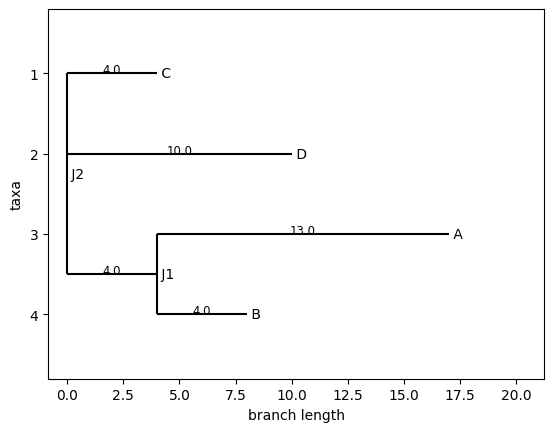

In [143]:
wiki_ex = neighbor_joining('wiki_ex.phy')
wiki_ex_handle = StringIO(wiki_ex)
wiki_ex_tree = Phylo.read(wiki_ex_handle, 'newick')

Phylo.draw(wiki_ex_tree, branch_labels = lambda c: c.branch_length if c.branch_length else "")

Provided testdata with five sequences from ```example_slide4.phy```

In [184]:
ex_slide4 = initiate_DM('example_slide4.phy')
ex_slide4_taxa = [i for i in ex_slide4]

NJ(ex_slide4_taxa, ex_slide4)

/var/folders/0_/gctnyx1572j56zv0974vkxmw0000gn/T/ipykernel_1257/3143813639.py:82: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if m != tuple(k):


[['B', 0.1, 'D', 0.07],
 ['A', 0.08, ('B', 'D'), 0.05],
 ['C', 0.05, 'E', 0.06],
 0.03]

{'J1': {'B': 0.1, 'D': 0.07}, 'J2': {'A': 0.08, 'J1': 0.05}, 'J3': {'C': 0.05, 'E': 0.06, 'J2': 0.03}}


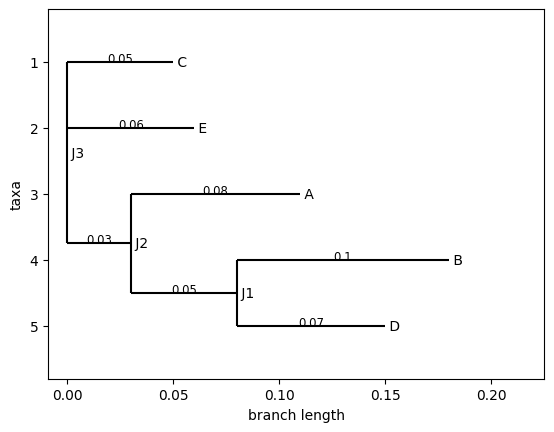

In [147]:
ex_slide4 = neighbor_joining('example_slide4.phy')
ex_slide4_handle = StringIO(ex_slide4)
ex_slide4_tree = Phylo.read(ex_slide4_handle, 'newick')

Phylo.draw(ex_slide4_tree, branch_labels = lambda c: c.branch_length if c.branch_length else '')

## <span style = 'color:cornflowerblue'>Experiments<span/>
From project 4, you know the programs QuickTree and RapidNJ that are implementations of the NJ methods. QuickTree implements the basic cubic time algorithm while RapidNJ implements an algorithm the is faster in practice.

You should compare the performance of your program against these two program in the following way.

The archive unique_distance_matrices.zip contains 14 distance matrices (in phylip-format) ranging in size from 89 to 1849 species. For each distance matrix, you should do the following:

1. Measure the time it takes to construct the corresponding NJ tree using QuickTree, RapidNJ, and your program.
2. Compute the RF-distances (using your program rfdist from project 4) between the trees produced by QuickTree, RapidNJ, and your program.

(If you want to investigate the running time of your program on more examples than provided in distance_matrices.zip, then you are welcome to download pfam_alignments.zip that contains 128 of alignment in Stockholm-format (from the Pfam database) aligning from 58 to 71535 species that you can convert to distance matrices in phylip-format using e.g. QuickTree. However, converting the big alignments to distance matrices would probably take too long and require too much space.)

In [ ]:
uniqueDistMatrices = sorted([file for file in os.listdir('unique_distance_matrices')], key = lambda x: int(x.split('_')[0]))

In [182]:
treedata = initiate_DM(f'unique_distance_matrices/{uniqueDistMatrices[2]}')
taxa = [i for i in treedata.keys()]

NJ(taxa, treedata)

/var/folders/0_/gctnyx1572j56zv0974vkxmw0000gn/T/ipykernel_1257/3143813639.py:82: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if m != tuple(k):


[['87_ASPP_A', 0.0, '88_Q177E0', 0.0],
 ['289_Q86QI', 0.0, '290_Q9310', 0.0],
 ['250_Q60W8', 0.0, '251_Q86NE', 0.0],
 ['252_Q86NE', 0.0, ('250_Q60W8', '251_Q86NE'), 0.0],
 ['297_O7683', 0.0, '298_Q9412', 0.0],
 ['299_Q9TVS', 0.0, ('297_O7683', '298_Q9412'), 0.0],
 ['55_Q26515', 0.0, '56_Q7JNB4', 0.0],
 ['73_Q6XQJ0', 0.0, '74_Q6YA65', 0.0],
 ['90_A1Z9Q9', 0.0, '91_Q8MZF3', 0.0],
 ['301_Q2503', 0.0, '302_Q9U8G', 0.0],
 ['268_Q5PR4', 0.0, '269_Q9DDE', 0.0],
 ['274_CATE', 0.0, '275_Q5TZ0', 0.0],
 ['276_Q5TZ0', 0.0, ('274_CATE', '275_Q5TZ0'), 0.0],
 ['288_Q9N9H', 0.06, ('289_Q86QI', '290_Q9310'), 0.08],
 ['32_Q52KV1', 0.0, '33_Q6DJP1', 0.0],
 ['34_Q804Z9', 0.0, ('32_Q52KV1', '33_Q6DJP1'), 0.0],
 ['83_Q4U5S3', 0.0, '84_Q7Z1E4', 0.0],
 ['80_Q7K485', 0.02, '81_Q292G7', 0.05],
 ['280_Q9PRT', -0.01, '281_Q9132', 0.01],
 ['60_RENI_H', 0.0, '61_RENI_P', 0.0],
 ['62_Q5NVA1', 0.0, '63_RENI_M', 0.0],
 ['64_RENI_M', 0.0, '65_Q6FI38', 0.0],
 [('60_RENI_H', '61_RENI_P'), 0.0, ('62_Q5NVA1', '63_RENI_M'),